In [2]:
%load_ext autoreload
%autoreload 2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data_ingestion import *
from src.feature_extraction import *
from src.baseline_model_training import *
from src.matrix_construction import *
from src.kernel import *
import warnings
warnings.filterwarnings('ignore')

### Loading Parameters

In [2]:
with open('config/test-params.json') as f:
    params = json.load(f)
sitemap = params['sitemap']
out = params['path']
num = params['num']
cat = params['cat']
malware_path = params['malware']

### Data Ingestion 

In [3]:
appurl = get_app_urls(sitemap, cat, num)

In [4]:
#benign apps
download_link(appurl, out, 'benign')

In [5]:
clean_disk(out)

Now all app files are left with manifest.xml and smalis only.

In [3]:
#malware
mal_paths = get_malware_paths(malware_path, num*cat)

### Feature Extraction and EDA

In [4]:
benign_df = generate_df(out, 'benign')

In [5]:
malware_df = generate_malware(mal_paths)

In [6]:
app_df = pd.concat([benign_df, malware_df])

In [25]:
app_df.head()

,num_code_block,num_uni_block,num_api,num_uni_api,num_package,num_uni_package,num_invoke,category
0,12745,12103,27386,8176,28484,1795,28484,0
1,44225,42806,138077,29101,139837,7621,139837,0
2,54186,51125,179486,34472,182836,8911,182836,0
3,31509,28555,108914,16709,111956,6322,111956,0
4,51368,48604,169719,33801,172583,8153,172583,0


In [26]:
app_df[app_df.num_api != 0].describe()

,num_code_block,num_uni_block,num_api,num_uni_api,num_package,num_uni_package,num_invoke,category
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,20339.829545,19240.477273,68039.954545,13227.306818,69554.420455,3473.227273,69554.420455,0.568182
std,21960.552460,20697.621925,70859.601656,13589.004650,72399.152363,3607.135918,72399.152363,0.498168
min,142.000000,140.000000,772.000000,278.000000,780.000000,118.000000,780.000000,0.000000
25%,1049.250000,991.000000,7177.750000,1218.750000,7265.000000,352.500000,7265.000000,0.000000
50%,4235.500000,4123.500000,21498.000000,3974.000000,22109.000000,919.500000,22109.000000,1.000000
75%,43235.000000,40760.000000,142144.000000,26475.500000,144883.250000,7264.250000,144883.250000,1.000000
max,58428.000000,54566.000000,213904.000000,36508.000000,221400.000000,10637.000000,221400.000000,1.000000


In [27]:
len(app_df) #split 49 benign / 50 malware

99

#### Histogram

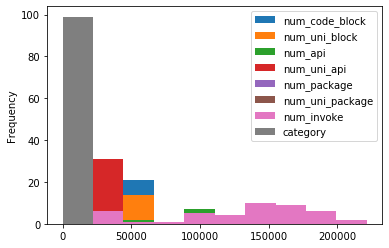

In [28]:
app_df.plot.hist()

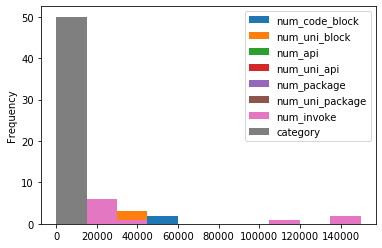

In [29]:
#malware only
app_df[app_df.category == 1].plot.hist()

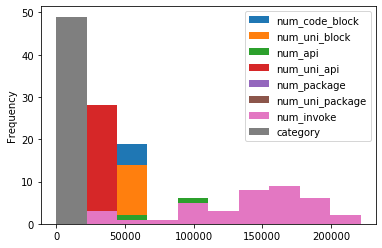

In [30]:
#benign only
app_df[app_df.category == 0].plot.hist()

In [4]:
benign_smali = all_smali(get_sub_dir(out + '/' + 'benign'))

In [5]:
mal_smali = all_smali(mal_paths)

In [33]:
ben_smali_df = pd.DataFrame(benign_smali)
mal_smali_df = pd.DataFrame(mal_smali)
together = ben_smali_df.append(mal_smali_df, ignore_index = True)
together.head()

,0
0,.class public Lorg/apache/http/ProtocolVersion...
1,.class Lnet/hockeyapp/android/FeedbackActivity...
2,.class public final Landroid/support/compat/R$...
3,.class Lc/a/a/a/a$a$a;\n.super Ljava/lang/Obje...
4,.class public final Lcom/igg/commonlibs/output...


In [34]:
A, apis = A(together)
sum_api = pd.DataFrame(A.todense(), columns = apis).sum().to_frame()

In [36]:
print('number of APIs appear once only:')
len(sum_api[sum_api[0] == 1])

number of APIs appear once only:


295829

When metapath entries gets too large, this data can be helpful by removing all API calls appear only once.

### Baseline Model

Features extracted above will be used for baseline model training including logistic regression, random forest, and gradient boost classifier.

In [12]:
X = app_df.drop('category', axis = 1)
y = app_df.category

In [10]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, shuffle = True)

In [18]:
metric_lr = Logistic_Regression(X_train, y_train, X_test, y_test)
lr = compute_metrics(list(metric_lr))

In [23]:
metric_rf = Random_Forest(X_train, y_train, X_test, y_test)
rf = compute_metrics(list(metric_rf))

In [26]:
metric_gbc = GBC(X_train, y_train, X_test, y_test)
bgc = compute_metrics(list(metric_gbc))

In [28]:
baseline = pd.DataFrame([lr, rf, bgc], index = ['logistic regression', 'random forest', 'gradient boost classifier'], columns = ['tn', 'fp', 'fn', 'tp', 'acc', 'fnr'])

In [29]:
baseline

,tn,fp,fn,tp,acc,fnr
logistic regression,11,5,2,15,0.787879,0.117647
random forest,15,1,1,16,0.939394,0.058824
gradient boost classifier,16,0,1,16,0.969697,0.058824


From the result dataframe, we can observe that the performace of logistic regression is not as good as the other two, and gradient boost classifier performs the best with an accuracy score of 0.97.

### The HIN

Now constructing model and kernels with the Hindroid approach. 

In [6]:
ben_smali_df = pd.DataFrame(benign_smali)
ben_smali_df['malware'] = 0
mal_smali_df = pd.DataFrame(mal_smali)
mal_smali_df['malware'] = 1

In [7]:
entire = ben_smali_df.append(mal_smali_df, ignore_index = True)

In [8]:
X = entire.drop('malware', axis = 1)
y = entire.malware

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, shuffle = True)

In [13]:
mA, mB, mP, mA_test = A_B_P(X_train, X_test)

In [14]:
mA.shape

(66, 337807)

In [15]:
mB.shape

(337807, 337807)

In [16]:
mP.shape

(337807, 337807)

In [17]:
kernels_train = kernel_train(mA, mB, mP)

In [18]:
kernels_test = kernel_test(mA, mA_test, mB, mP)

#### AA^T

In [42]:
aa= SVM_result(kernels_train[0].todense(), kernels_test[0].todense(), y_train, y_test)
aa_train = aa['train']
aa_test = aa['test']

#### ABA^T

In [43]:
aba = SVM_result(kernels_train[1].todense(), kernels_test[1].todense(), y_train, y_test)
aba_train = aba['train']
aba_test = aba['test']

#### APA^T

In [44]:
apa= SVM_result(kernels_train[2].todense(), kernels_test[2].todense(), y_train, y_test)
apa_train = apa['train']
apa_test = apa['test']

#### APBP^TA^T

In [45]:
apbpa = SVM_result(kernels_train[3].todense(), kernels_test[3].todense(), y_train, y_test)
apbpa_train = apbpa['train']
apbpa_test = apbpa['test']

#### HIN Result on Training

In [49]:
HIN_train = pd.DataFrame([aa_train, aba_train, apa_train, apbpa_train], index = ['AA^T', 'ABA^T', 'APA^T', 'APBP^TA^T'], columns = ['tn', 'fp', 'fn', 'tp', 'acc', 'fnr'])

In [51]:
HIN_train

,tn,fp,fn,tp,acc,fnr
AA^T,32,0,0,34,1.000000,0.0
ABA^T,0,32,0,34,0.515152,0.0
APA^T,32,0,0,34,1.000000,0.0
APBP^TA^T,0,32,0,34,0.515152,0.0


#### HIN Result on Test

In [52]:
HIN_test = pd.DataFrame([aa_test, aba_test, apa_test, apbpa_test], index = ['AA^T', 'ABA^T', 'APA^T', 'APBP^TA^T'], columns = ['tn', 'fp', 'fn', 'tp', 'acc', 'fnr'])

In [53]:
HIN_test

,tn,fp,fn,tp,acc,fnr
AA^T,16,1,0,16,0.969697,0.0000
ABA^T,0,17,0,16,0.484848,0.0000
APA^T,15,2,3,13,0.848485,0.1875
APBP^TA^T,0,17,0,16,0.484848,0.0000


In [12]:
run_kernel(X, y)

Matrices construction:
--- start
--- saving matrics
--- Done!
Kernel construction:
--- start
--- Done!
SVM training:
--- start
25%
50%
75%
100%
--- saving result metrics
--- Finished all kernel tasks!
